In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import nltk
import re 
from sklearn.cluster import AgglomerativeClustering
nltk.download('vader_lexicon')
from sklearn.metrics import silhouette_score
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.cluster import KMeans
from operator import itemgetter
import random
from gensim import corpora
from gensim.models import LsiModel
from gensim.models.coherencemodel import CoherenceModel
from nltk.tokenize import RegexpTokenizer
from gensim.models import TfidfModel

def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=num_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

def plot_graph(doc_clean,start, stop, step):
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean, stop, start, step)
    # Show graph
    #print(coherence_values)
    #x = range(start, stop, step)
    #plt.plot(x, coherence_values)
    #plt.xlabel("Number of Topics")
    #plt.ylabel("Coherence score")
    #plt.legend(("coherence_values"), loc='best')
    #plt.show()
    c = coherence_values.index(max(coherence_values))
    return start + c

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/menis/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [3]:
data = pd.read_json("5campaignNew.json")
from nltk.sentiment.vader import SentimentIntensityAnalyzer
vader = SentimentIntensityAnalyzer()
text = data["text"].tolist()
scores = list()
positive = list()
negative = list()
neut = list()
for t in text:
    scores.append(vader.polarity_scores(t)['compound'])
    positive.append(vader.polarity_scores(t)['pos'])
    negative.append(vader.polarity_scores(t)['neg'])
    neut.append(vader.polarity_scores(t)['neu'])

In [ ]:
#&amp; is the html special character for &!!!!!! rimuovi!
#data.reset_index(drop=True,inplace=True)
#data.iloc[1332]["text"]

In [4]:
data["vaderScore"] = scores
#prova a togliere retweet
data = data[data["is_retweet"] == False]
#prova a togliere numeri staccati da altre parole
temp = []
for idx,row in data.iterrows():
    s = row["modded1_stemmed"]
    c = re.sub(" \d+", " ", s)
    temp.append(c)

data["modded1_stemmed"] = temp

data.rename(index=str, columns={"year": "date_year"},inplace=True)

data.drop(["in_reply_to_user_id_str","is_retweet","text","modded_text","modded1","date"],axis=1,inplace=True)
data.corr()

,favorite_count,retweet_count,month,date_year,hour,week_year,labels,vaderScore
favorite_count,1.000000,0.942623,0.254780,0.528035,0.062206,0.243036,0.062757,-0.064684
retweet_count,0.942623,1.000000,0.238841,0.478344,0.068476,0.228411,0.053946,-0.086814
month,0.254780,0.238841,1.000000,-0.057566,0.078576,0.976885,0.016544,-0.043517
date_year,0.528035,0.478344,-0.057566,1.000000,0.103089,-0.060208,0.056769,-0.086559
hour,0.062206,0.068476,0.078576,0.103089,1.000000,0.079265,0.061342,-0.043853
week_year,0.243036,0.228411,0.976885,-0.060208,0.079265,1.000000,0.011125,-0.043497
labels,0.062757,0.053946,0.016544,0.056769,0.061342,0.011125,1.000000,-0.018411
vaderScore,-0.064684,-0.086814,-0.043517,-0.086559,-0.043853,-0.043497,-0.018411,1.000000


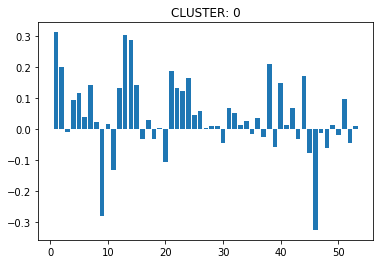

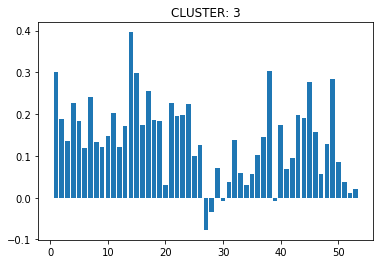

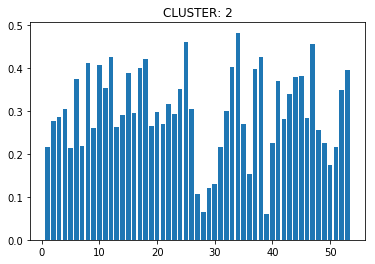

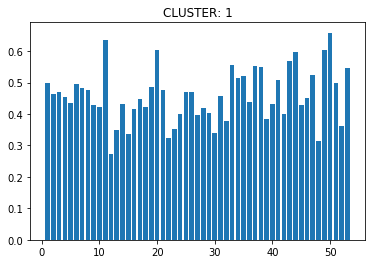

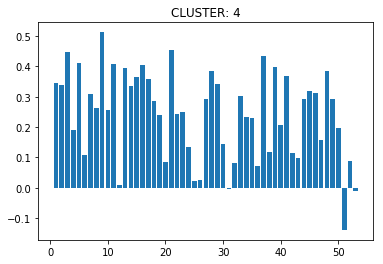

In [5]:
for cluster in data["labels"].unique():    
    time = data[data["labels"] == cluster]
    time = time.groupby(["week_year"])["vaderScore"].mean()
    plt.title("CLUSTER: " + str(cluster))
    plt.bar(time.index, time )
    plt.show()

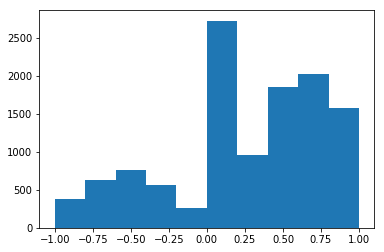

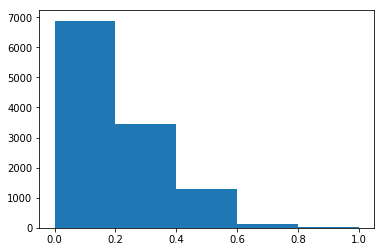

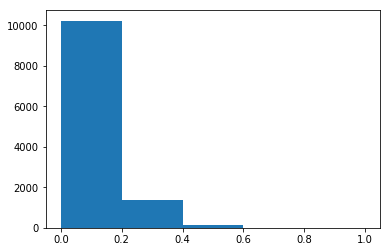

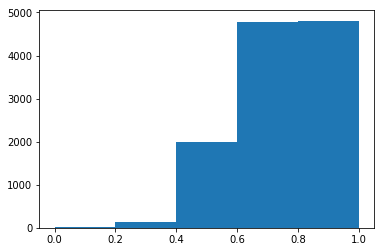

In [11]:
plt.hist(scores,bins=[-1,-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8,1])
plt.show()

plt.hist(positive,bins=[0,0.2,0.4,0.6,0.8,1])
plt.show()

plt.hist(negative,bins=[0,0.2,0.4,0.6,0.8,1])
plt.show()

plt.hist(neut,bins=[0,0.2,0.4,0.6,0.8,1])
plt.show()

In [7]:
x1 = data[data["labels"] == 0]
print(len(x1))
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# create a dataframe from a word matrix
def wm2df(wm, feat_names):
    
    # create an index for each row
    doc_names = ['Doc{:d}'.format(idx) for idx, _ in enumerate(wm)]
    df = pd.DataFrame(data=wm.toarray(),
                      columns=feat_names)
    return(df)
    
stemmed_words = pd.Series(' '.join(data['modded1_stemmed']).split()).value_counts()
stemmed_words = stemmed_words[stemmed_words < 2000]
stemmed_words = stemmed_words[stemmed_words > 3]
x1['m'] = data['modded1_stemmed'].apply(lambda x: " ".join(x for x in x.split() if x in stemmed_words))

corpus = x1["m"].tolist()

# instantiate the vectorizer object
cvec = TfidfVectorizer()

# convert the documents into a document-term matrix
wm = cvec.fit_transform(corpus)

# retrieve the terms found in the corpora
tokens = cvec.get_feature_names()

# create a dataframe from the matrix
c = wm2df(wm, tokens)

1722


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(array([2.73e+03, 6.60e+01, 1.90e+01, 9.00e+00, 6.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 1.00e+00, 1.00e+00]),
 array([   4. ,  167.9,  331.8,  495.7,  659.6,  823.5,  987.4, 1151.3,
        1315.2, 1479.1, 1643. ]),
 <a list of 10 Patch objects>)

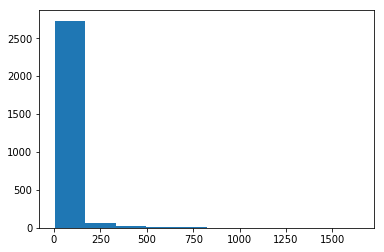

In [8]:
plt.hist(stemmed_words)

In [11]:
x1.reset_index(inplace=True,drop=True)
res = pd.concat([x1,c], axis=1)
#hour peggiora di brutto e monht alza di tanto sse!!!
res1 = res.drop(["month","hour","noTags_punct","modded1_stemmed","labels","favorite_count","retweet_count","m"],axis=1)
dataWithText = res.drop(["month","hour","noTags_punct","modded1_stemmed","labels","favorite_count","retweet_count"],axis=1) 

In [12]:
res1.columns

Index(['date_year', 'week_year', 'vaderScore', '_snurk', '_vinc', 'aacrowellt',
       'abc', 'abil', 'abl', 'aboard',
       ...
       'yorker', 'youll', 'young', 'your', 'youtub', 'youv', 'yr', 'zero',
       'zogbi', 'zuckerman'],
      dtype='object', length=2253)

# K means

In [ ]:
res1 = res.drop(["week_year","month","hour","noTags_punct","modded1_stemmed","labels","favorite_count","retweet_count","m"],axis=1)
dataWithText = res.drop(["month","hour","noTags_punct","modded1_stemmed","labels","favorite_count","retweet_count"],axis=1) 
res1.columns

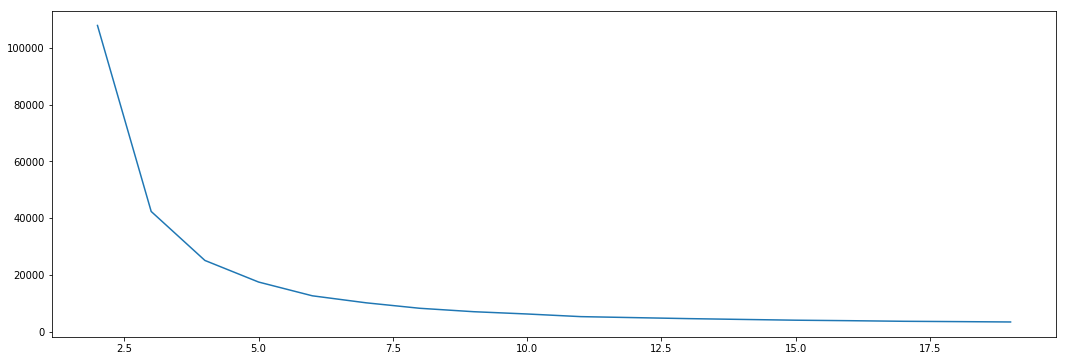

CPU times: user 4min 9s, sys: 7min 15s, total: 11min 25s
Wall time: 34.7 s


In [13]:
%%time
sse_list = list()
max_k = 20
plt.figure(figsize=(18,6))
for k in range(2,max_k):
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(res1)
    sse = kmeans.inertia_
    sse_list.append(sse)
plt.plot(range(2,max_k), sse_list)
plt.show()
#1724 senza week, year; 20000 con 

In [14]:
#6 per il label 1 (15 cluster)
#monthe vader alzano la silhouette

#per label 2 week year peggiora sse ma aumenta silhouette
#solo vader e tfidf abbassano di un botto l'sse per label 2


#sembra che usare week year peggiori l'sse ma aumenti di molto la silhouette. Come interpretare? cosa preferire?
true_k =5
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=10)
model.fit(res1)
print(model.inertia_)
print
labels = model.labels_
res1["labels"] = labels
dataWithText["labels"] = labels
d = silhouette_score(res1, labels,metric='euclidean')
print(d)

17516.980725809462


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


0.5685457565749095


In [35]:
g = res1.drop(["vaderScore"],axis=1)

for cluster in g["labels"].unique():
    g1 = g[g["labels"] == cluster]
    d1 = dataWithText[dataWithText["labels"] == cluster]
    if len(g1) >= 2:
        meanTf = []
        for column in g1.columns:
            if column != "labels":
                m = g1[column].mean()
                meanTf.append([column,m])

        meanTfOrdered = sorted(meanTf, key=itemgetter(1),reverse = True)
        #print("cluster ",cluster," lunghezza ", len(g1), ":\n", str(meanTfOrdered[0:5]) + "\n")

        tokenizer = RegexpTokenizer(r'\w+')
        counted = pd.Series(' '.join(d1['m']).split()).value_counts()
        #counted = counted[5:] #5 per label 1 
        #counted = counted[counted > ]
        d1['m'] = d1['m'].apply(lambda x: " ".join(x for x in x.split() if x in counted))

        corpus = d1["m"].tolist()
        #print(len(corpus))
        corp = []
        for string in corpus:
            tokens = tokenizer.tokenize(string)
            corp.append(tokens)

        dictionary = corpora.Dictionary(corp)
        doc_term_matrix = [dictionary.doc2bow(doc) for doc in corp]
        tfidf = TfidfModel(doc_term_matrix)
        tfidf_corpus = tfidf[doc_term_matrix]

        start,stop,step=1,10,1
        nTopics = plot_graph(corp,start,stop,step)
        print("cluster ",cluster," lunghezza ", len(g1))
        print("NUMBER OF TOPICS FOR CLUSTER ", cluster, " : ", nTopics)
        words = 7
        lsamodel = LsiModel(tfidf_corpus, num_topics=nTopics, id2word = dictionary)  # train model
        #print(lsamodel.show_topics(num_topics = -1,num_words = words))

        plt.hist(d1["vaderScore"],bins=[-1,-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8,1])
        plt.title("Sentiment score for cluster: " + str(cluster))
        plt.show()
        
        print(d1["date_year"].unique().tolist())
        print("numero di settimane in cluster", len(d1["week_year"].unique().tolist()))
        time = d1.groupby(["week_year"])["vaderScore"].mean()
        plt.title("CLUSTER: " + str(cluster))
        plt.bar(time.index, time )
        plt.show()

        topics = lsamodel.show_topics(num_topics=-1, num_words=10, log=True, formatted=False)
        #print(g)
        for topic in topics:
            words = []
            weights = []
            for word in topic[1]:
                if abs(word[1]) > 0.05:
                    words.append(word[0])
                    #prendi valore assoluto perchè positivo/negativo non ha senso 
                    weights.append(abs(word[1]))
            labels = words
            sizes = weights
            plt.title("topic " + str(topic[0]) + " in cluster " + str(cluster))
            #manca il pie o la rappresentazione
            sns.barplot(x=weights, y=words)
            plt.show()

KeyError: 'labels'

# Hierarchical

In [24]:
from sklearn.cluster import AgglomerativeClustering
sil = []
for c in range(2,12):
    clustering = AgglomerativeClustering(affinity='cosine', linkage='average', n_clusters=c)
    clustering.fit(res1)
    labels = clustering.labels_
    d = silhouette_score(res1, labels,metric='cosine')
    sil.append(d)
    print(c,d)

2 0.7785765065133365
3 0.6761501958866973
4 0.7376193717990409
5 0.7130094259846771
6 0.6640710643358757
7 0.6325790108995364
8 0.5648336294640788
9 0.5788257032759734
10 0.5633159499789054
11 0.5748584167866928


In [23]:
res1.columns

Index(['date_year', 'week_year', 'vaderScore', '_snurk', '_vinc', 'aacrowellt',
       'abc', 'abil', 'abl', 'aboard',
       ...
       'yorker', 'youll', 'young', 'your', 'youtub', 'youv', 'yr', 'zero',
       'zogbi', 'zuckerman'],
      dtype='object', length=2253)

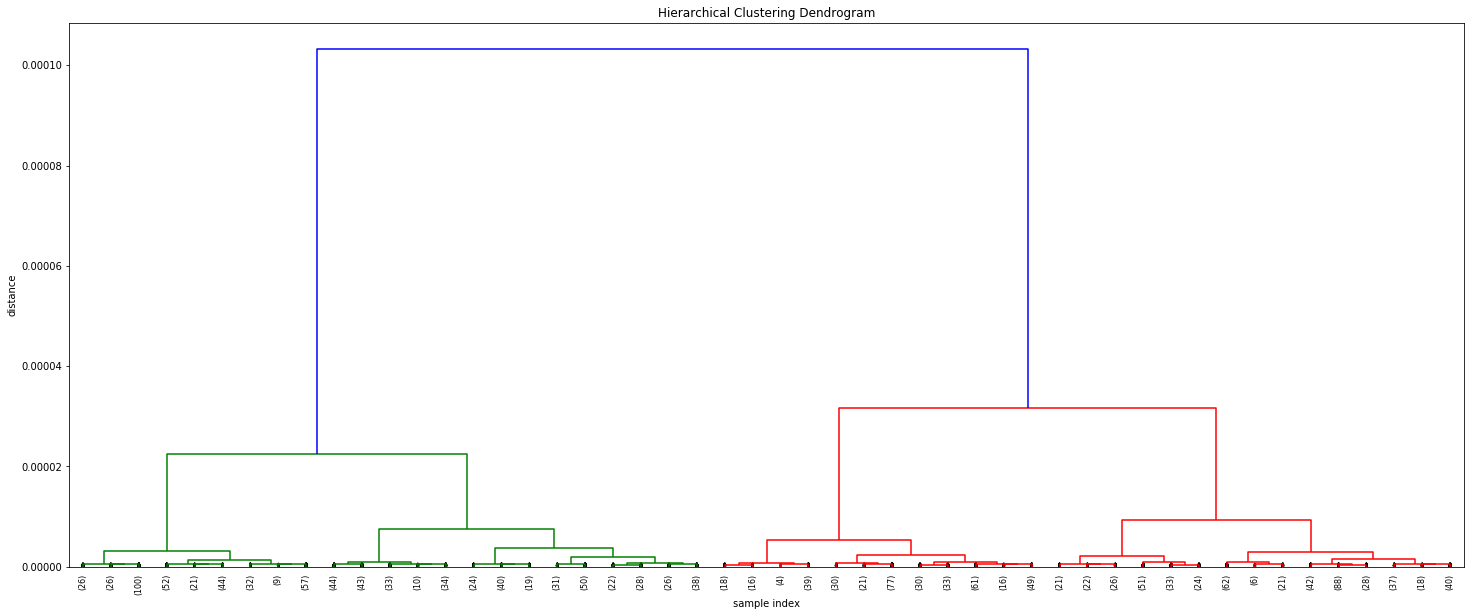

In [37]:
res1 = res.drop(["month","hour","noTags_punct","modded1_stemmed","labels","favorite_count","retweet_count","m"],axis=1)
dataWithText = res.drop(["month","hour","noTags_punct","modded1_stemmed","labels","favorite_count","retweet_count"],axis=1) 

from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(res1, 'average', "cosine")
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=50,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
    show_contracted=True,
)
plt.show()


In [38]:
clustering = AgglomerativeClustering(affinity='cosine', linkage='average', n_clusters=20) #50 sembra nice, 70 meh 
clustering.fit(res1)
labels = clustering.labels_
d = silhouette_score(res1, labels,metric='cosine')
print(d)



0.4951913830317486


In [39]:
res1["labels"] = labels
dataWithText["labels"] = labels

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


cluster  8  lunghezza  152
NUMBER OF TOPICS FOR CLUSTER  8  :  1


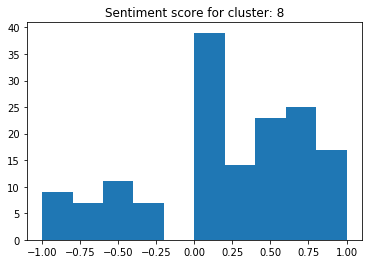

[2015, 2016]
numero di settimane in cluster 3


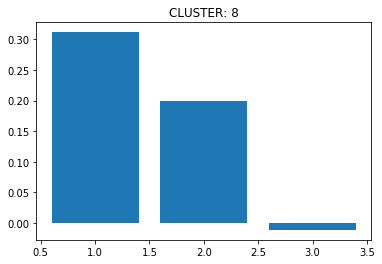

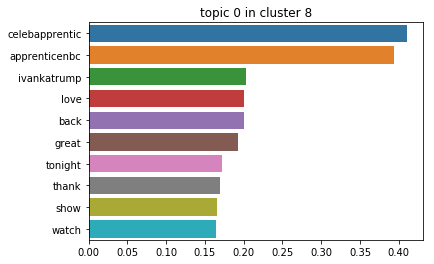

cluster  4  lunghezza  98
NUMBER OF TOPICS FOR CLUSTER  4  :  2


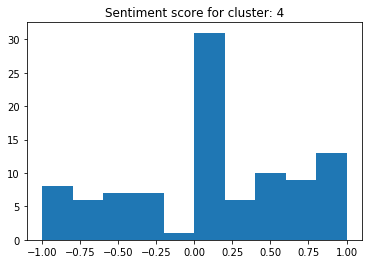

[2015, 2016]
numero di settimane in cluster 3


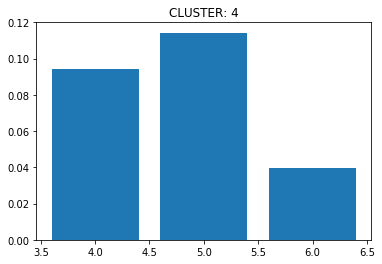

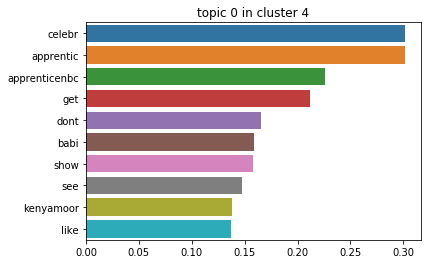

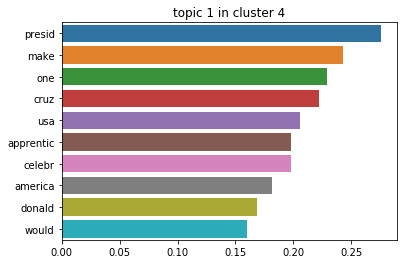

cluster  6  lunghezza  117
NUMBER OF TOPICS FOR CLUSTER  6  :  1


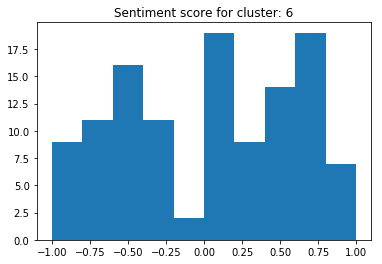

[2015, 2016]
numero di settimane in cluster 3


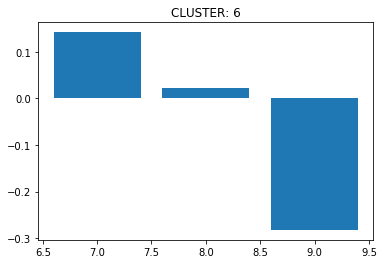

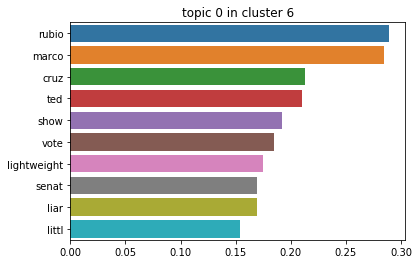

cluster  7  lunghezza  83
NUMBER OF TOPICS FOR CLUSTER  7  :  1


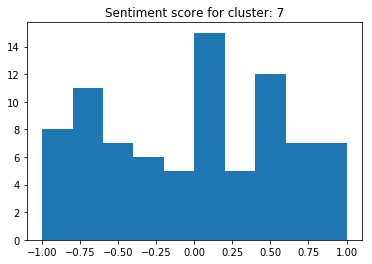

[2015, 2016]
numero di settimane in cluster 3


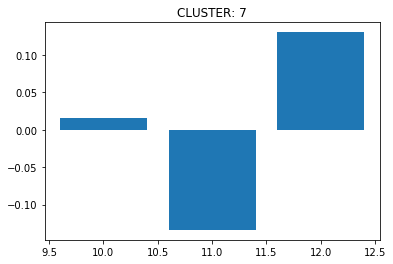

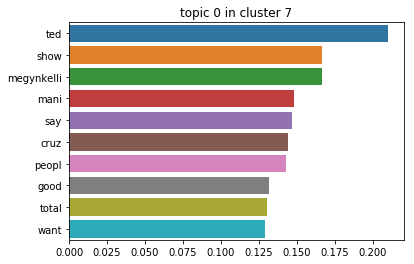

cluster  19  lunghezza  50
NUMBER OF TOPICS FOR CLUSTER  19  :  1


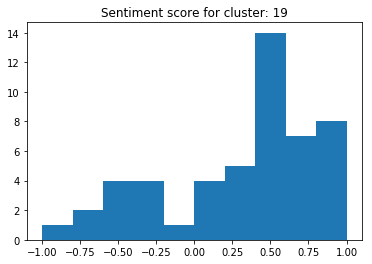

[2015, 2016]
numero di settimane in cluster 2


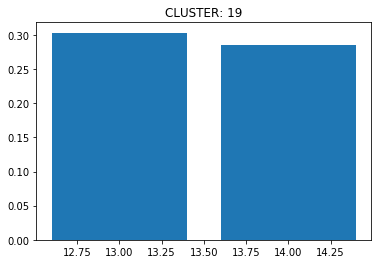

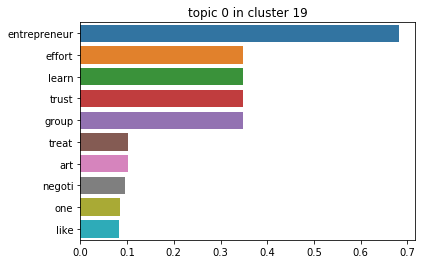

cluster  12  lunghezza  64
NUMBER OF TOPICS FOR CLUSTER  12  :  7


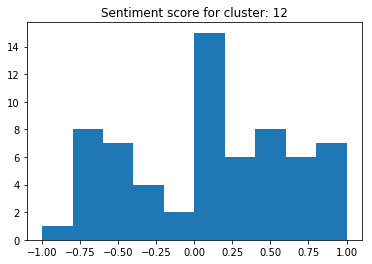

[2015, 2016]
numero di settimane in cluster 2


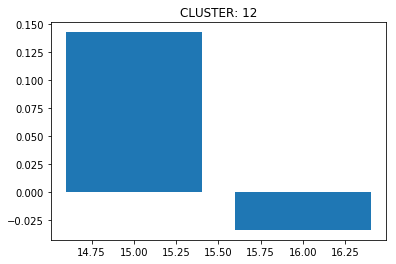

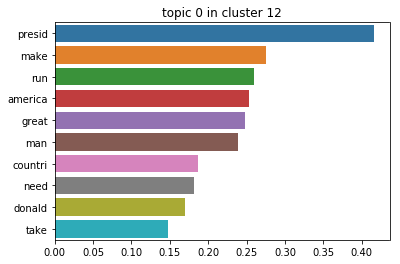

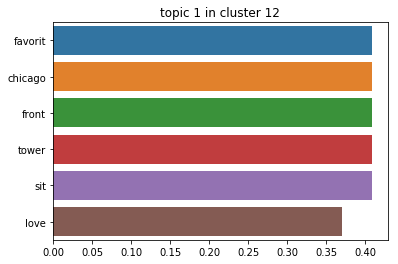

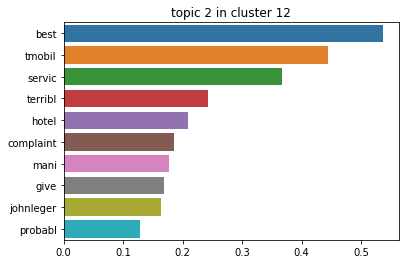

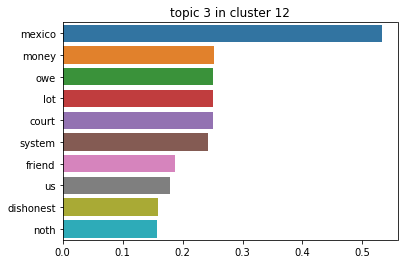

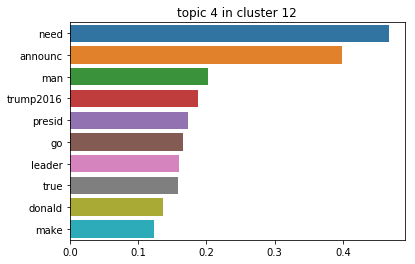

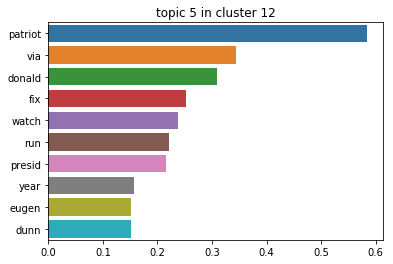

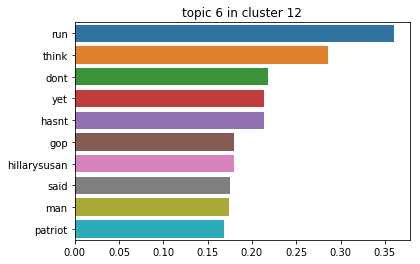

cluster  2  lunghezza  81
NUMBER OF TOPICS FOR CLUSTER  2  :  4


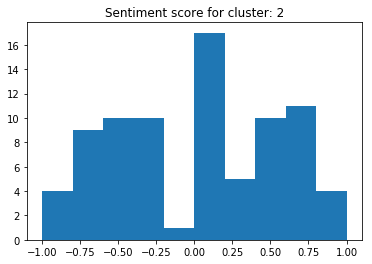

[2015, 2016]
numero di settimane in cluster 3


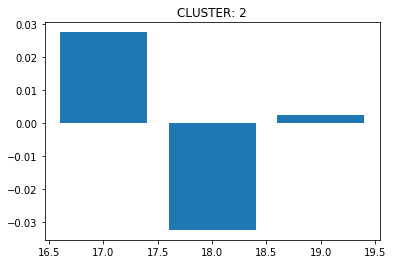

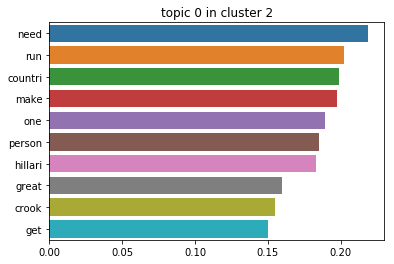

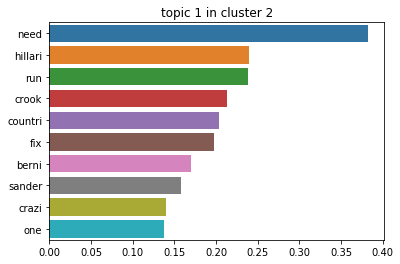

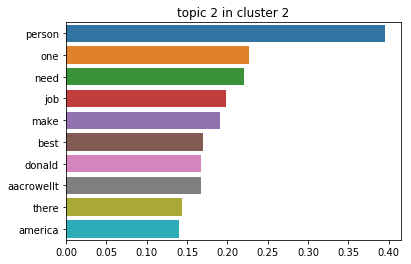

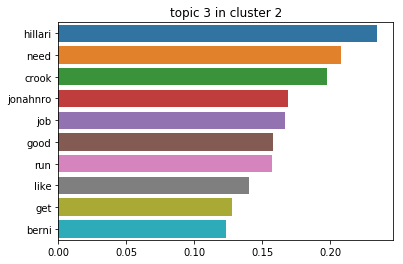

cluster  16  lunghezza  87
NUMBER OF TOPICS FOR CLUSTER  16  :  1


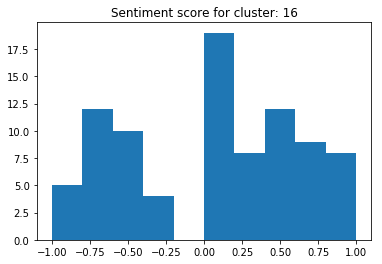

[2015, 2016]
numero di settimane in cluster 2


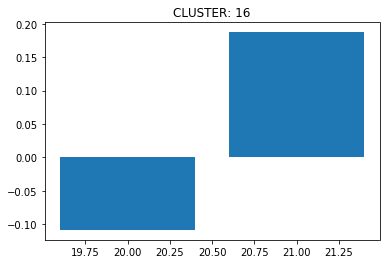

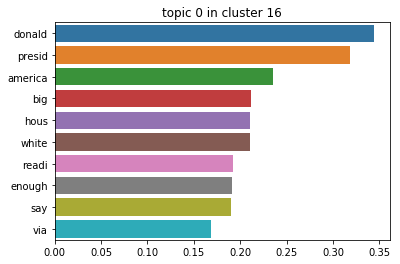

cluster  10  lunghezza  77
NUMBER OF TOPICS FOR CLUSTER  10  :  1


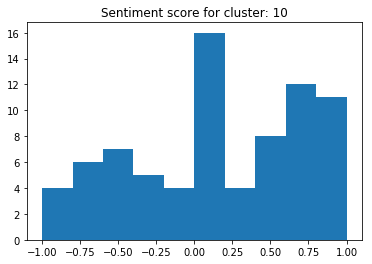

[2015, 2016]
numero di settimane in cluster 3


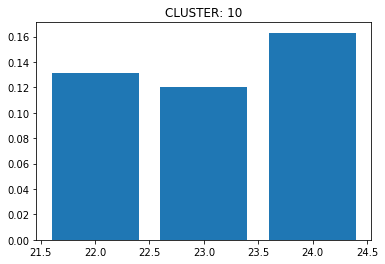

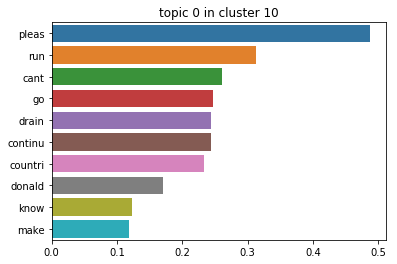

cluster  1  lunghezza  128
NUMBER OF TOPICS FOR CLUSTER  1  :  1


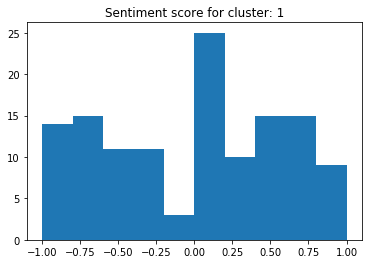

[2015, 2016]
numero di settimane in cluster 4


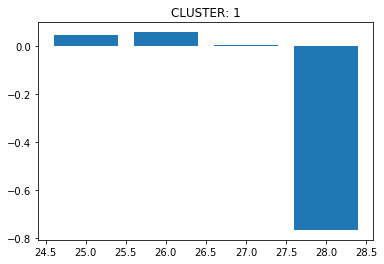

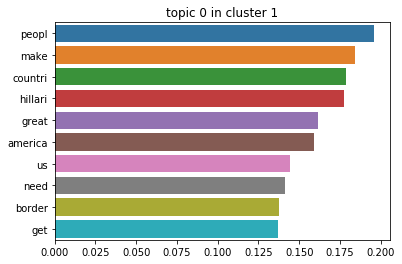

cluster  5  lunghezza  126
NUMBER OF TOPICS FOR CLUSTER  5  :  9


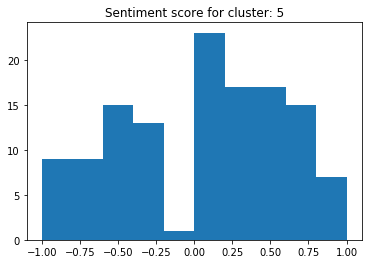

[2015, 2016]
numero di settimane in cluster 3


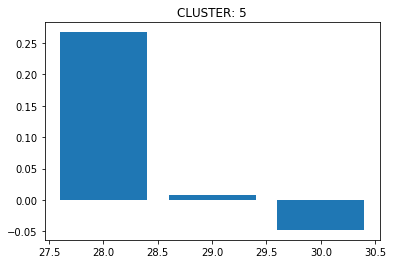

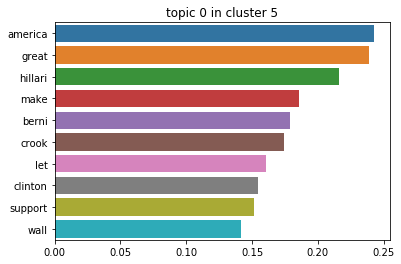

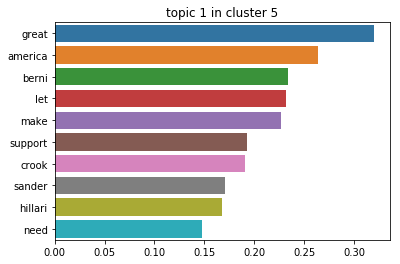

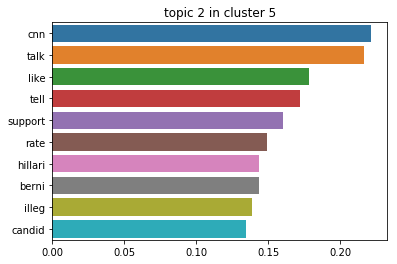

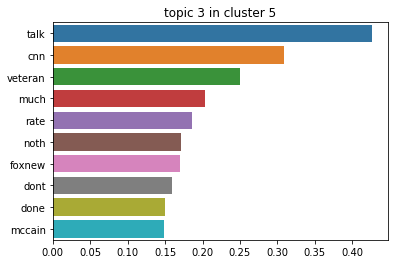

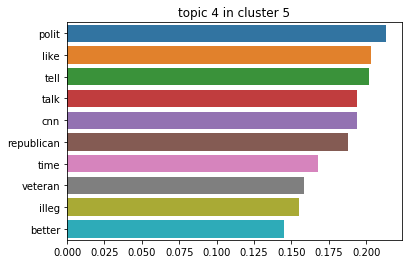

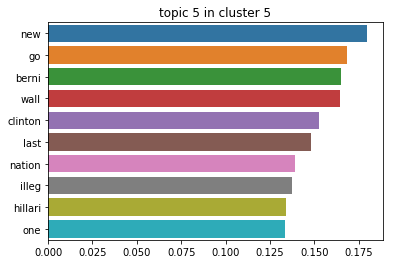

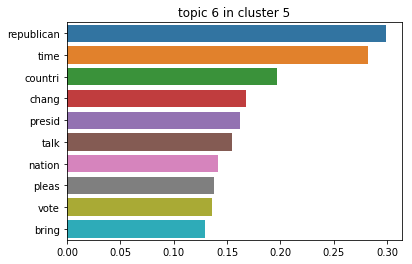

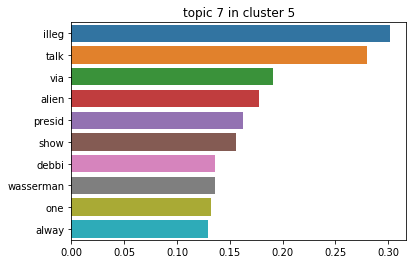

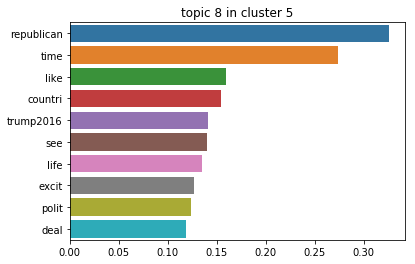

cluster  15  lunghezza  63
NUMBER OF TOPICS FOR CLUSTER  15  :  1


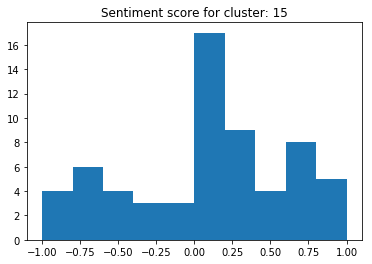

[2015, 2016]
numero di settimane in cluster 2


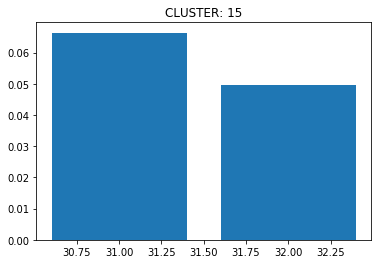

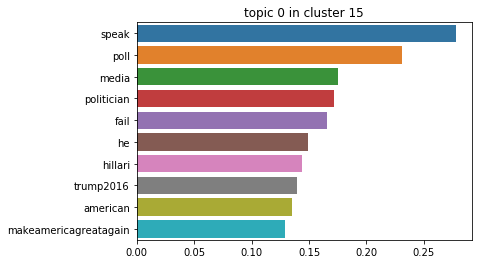

cluster  0  lunghezza  77
NUMBER OF TOPICS FOR CLUSTER  0  :  1


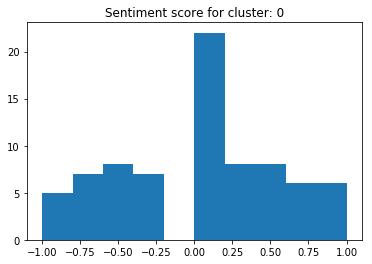

[2015, 2016]
numero di settimane in cluster 4


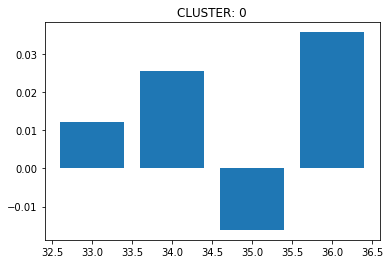

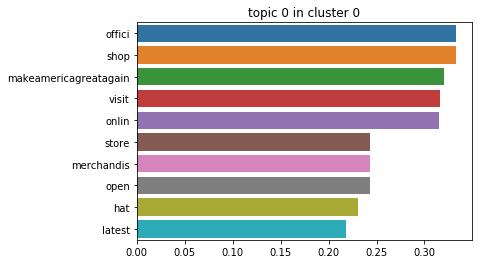

cluster  14  lunghezza  27
NUMBER OF TOPICS FOR CLUSTER  14  :  2


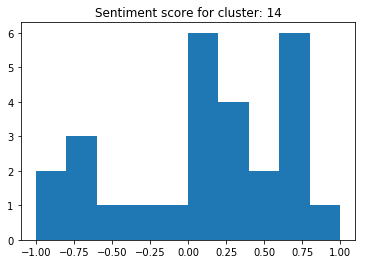

[2015, 2016]
numero di settimane in cluster 2


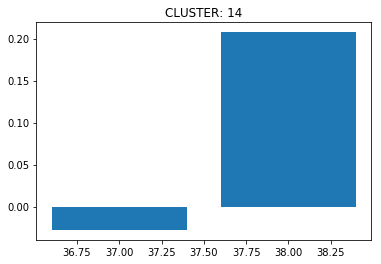

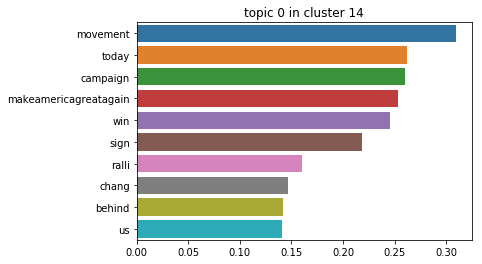

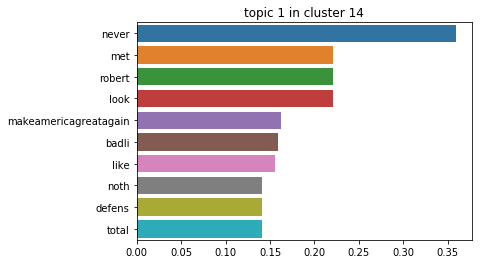

cluster  18  lunghezza  62
NUMBER OF TOPICS FOR CLUSTER  18  :  1


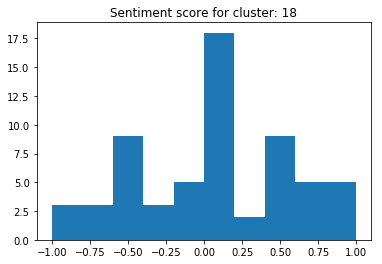

[2015, 2016]
numero di settimane in cluster 2


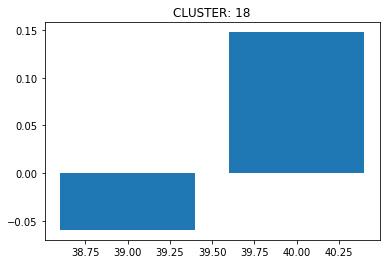

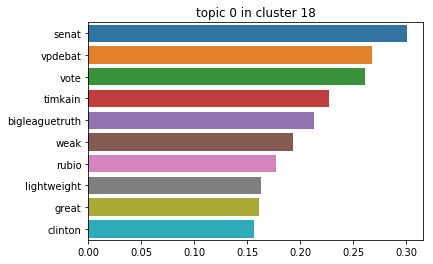

cluster  13  lunghezza  158
NUMBER OF TOPICS FOR CLUSTER  13  :  1


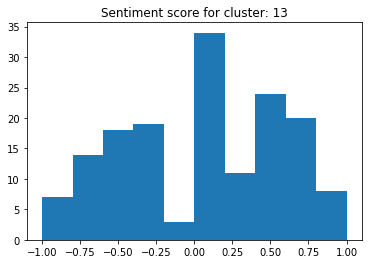

[2015, 2016]
numero di settimane in cluster 3


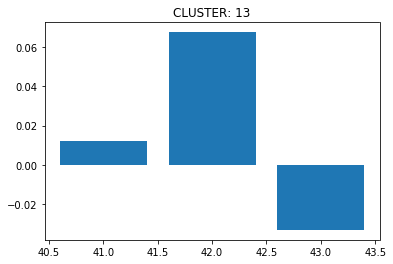

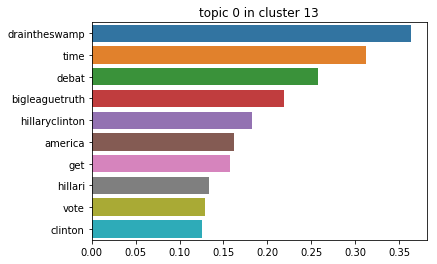

cluster  3  lunghezza  95
NUMBER OF TOPICS FOR CLUSTER  3  :  1


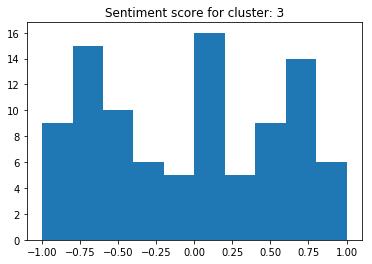

[2015, 2016]
numero di settimane in cluster 3


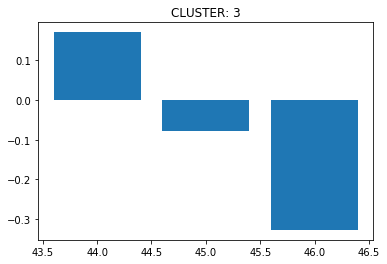

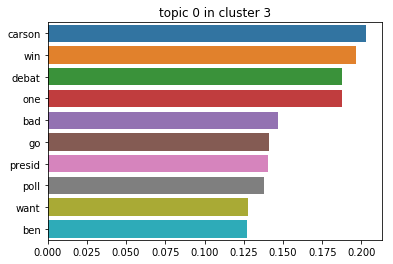

cluster  17  lunghezza  51
NUMBER OF TOPICS FOR CLUSTER  17  :  1


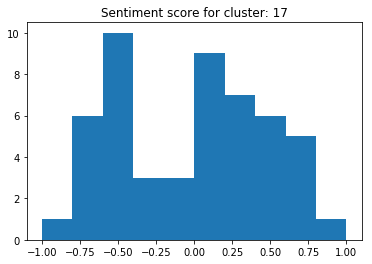

[2015, 2016]
numero di settimane in cluster 2


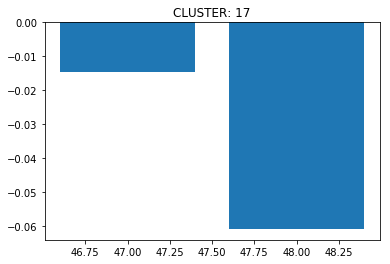

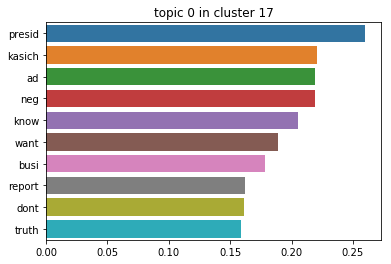

cluster  9  lunghezza  57
NUMBER OF TOPICS FOR CLUSTER  9  :  2


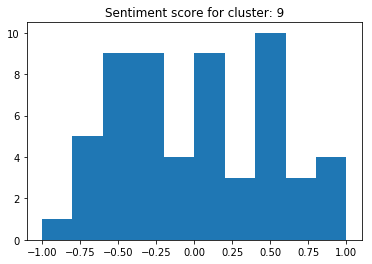

[2015, 2016]
numero di settimane in cluster 2


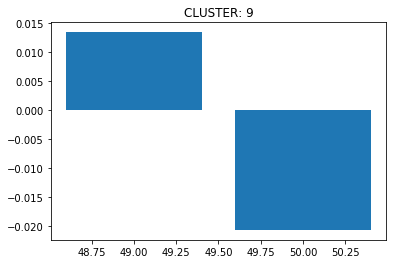

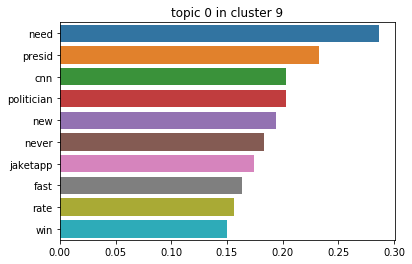

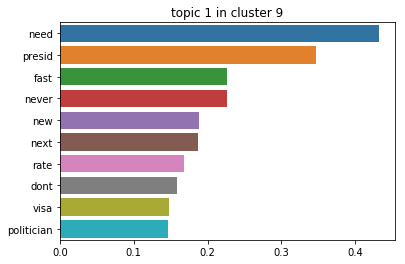

cluster  11  lunghezza  69
NUMBER OF TOPICS FOR CLUSTER  11  :  1


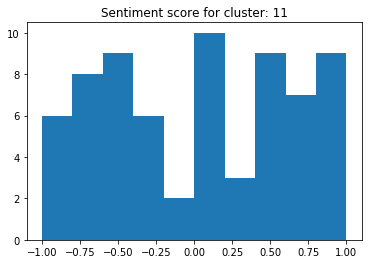

[2015, 2016]
numero di settimane in cluster 3


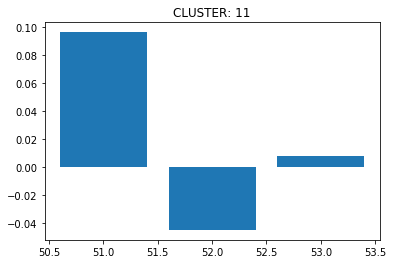

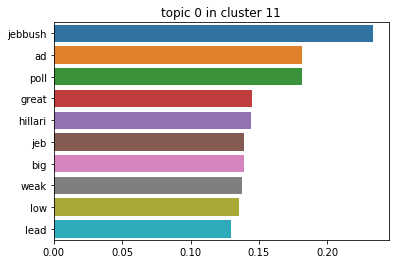

In [40]:
g = res1.drop(["vaderScore"],axis=1)

for cluster in g["labels"].unique():
    g1 = g[g["labels"] == cluster]
    d1 = dataWithText[dataWithText["labels"] == cluster]
    if len(g1) >= 4:
        meanTf = []
        for column in g1.columns:
            if column != "labels":
                m = g1[column].mean()
                meanTf.append([column,m])

        meanTfOrdered = sorted(meanTf, key=itemgetter(1),reverse = True)
        #print("cluster ",cluster," lunghezza ", len(g1), ":\n", str(meanTfOrdered[0:5]) + "\n")

        tokenizer = RegexpTokenizer(r'\w+')
        counted = pd.Series(' '.join(d1['m']).split()).value_counts()
        #counted = counted[5:] #5 per label 1 
        #counted = counted[counted > ]
        d1['m'] = d1['m'].apply(lambda x: " ".join(x for x in x.split() if x in counted))

        corpus = d1["m"].tolist()
        #print(len(corpus))
        corp = []
        for string in corpus:
            tokens = tokenizer.tokenize(string)
            corp.append(tokens)

        dictionary = corpora.Dictionary(corp)
        doc_term_matrix = [dictionary.doc2bow(doc) for doc in corp]
        tfidf = TfidfModel(doc_term_matrix)
        tfidf_corpus = tfidf[doc_term_matrix]

        start,stop,step=1,10,1
        nTopics = plot_graph(corp,start,stop,step)
        print("cluster ",cluster," lunghezza ", len(g1))
        print("NUMBER OF TOPICS FOR CLUSTER ", cluster, " : ", nTopics)
        words = 7
        lsamodel = LsiModel(tfidf_corpus, num_topics=nTopics, id2word = dictionary)  # train model
        #print(lsamodel.show_topics(num_topics = -1,num_words = words))

        plt.hist(d1["vaderScore"],bins=[-1,-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8,1])
        plt.title("Sentiment score for cluster: " + str(cluster))
        plt.show()
        
        print(d1["date_year"].unique().tolist())
        print("numero di settimane in cluster", len(d1["week_year"].unique().tolist()))
        time = d1.groupby(["week_year"])["vaderScore"].mean()
        plt.title("CLUSTER: " + str(cluster))
        plt.bar(time.index, time )
        plt.show()

        #piechart
        topics = lsamodel.show_topics(num_topics=-1, num_words=10, log=True, formatted=False)
        #print(g)
        for topic in topics:
            words = []
            weights = []
            for word in topic[1]:
                if abs(word[1]) > 0.05:
                    words.append(word[0])
                    #prendi valore assoluto perchè positivo/negativo non ha senso 
                    weights.append(abs(word[1]))
            labels = words
            sizes = weights
            plt.title("topic " + str(topic[0]) + " in cluster " + str(cluster))
            #manca il pie o la rappresentazione
            sns.barplot(x=weights, y=words)
            plt.show()